In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, classification_report

from datawig import Imputer
from datawig.column_encoders import *
from datawig.mxnet_input_symbols import *
from datawig.utils import random_split

from impyute.imputation.cs import mice

from math import sqrt
import random
import numpy as np
import pandas as pd
random.seed(0)

### Dataset
Data: https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset

Data Set Characteristics:

- Number of Instances:
    20640

- Number of Attributes: 8 numeric, predictive attributes and the target

- Attribute Information:

 	-- MedInc median income in block
    
    -- HouseAge median house age in block
    
    -- AveRooms average number of rooms
    
    -- AveBedrms average number of bedrooms
    
    -- Population block population
    
    -- AveOccup average house occupancy
    
    -- Latitude house block latitude
    
    -- Longitude house block longitude
   
- Missing Attribute Values:

 	-- None

In [2]:
#Fetching the dataset
dataset = fetch_california_housing()
train, target = pd.DataFrame(dataset.data), pd.DataFrame(dataset.target)
train.columns = ['0','1','2','3','4','5','6','7']
train.insert(loc=len(train.columns), column='target', value=target)

In [3]:
train.shape

(20640, 9)

In [4]:
train_df = train.iloc[0:20000,:]
test_df = train.iloc[20000:,:]

In [5]:
print(train_df.shape)
print(test_df.shape)

(20000, 9)
(640, 9)


In [6]:
sum(test_df['0'].isna())

0

In [7]:
original_column = test_df['0'].copy(deep=True)

In [8]:
#Randomly replace 40% of the first column with NaN values
column = test_df['0']
print(column.size)
missing_pct = int(column.size * 0.4)
print(missing_pct)
i = [random.choice(range(20000, 20640, 1)) for _ in range(missing_pct)]
print(len(i))
column[i] = np.NaN
print(column.shape[0])


640
256
256
640


/Users/uditagupta/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:977: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_labels(key, value)
/Users/uditagupta/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
test_df

,0,1,2,3,4,5,6,7,target
20000,NaN,39.0,5.228571,1.137143,580.0,3.314286,36.04,-119.40,1.125
20001,NaN,29.0,7.257143,1.242857,481.0,3.435714,36.05,-119.27,1.125
20002,1.7432,30.0,4.120448,1.044818,1418.0,3.971989,36.10,-119.21,0.425
20003,1.9091,29.0,5.353982,1.109145,1421.0,4.191740,36.06,-119.19,0.713
20004,3.9000,41.0,5.883721,1.085271,408.0,3.162791,36.14,-119.19,0.859
20005,2.0586,28.0,4.509434,1.037736,1434.0,3.865229,36.13,-119.13,0.409
20006,3.1528,21.0,6.104839,1.010753,1145.0,3.077957,36.13,-119.08,1.137
20007,1.7106,24.0,5.718987,1.032911,1169.0,2.959494,36.13,-119.03,0.955
20008,1.6354,20.0,5.190283,1.105263,852.0,3.449393,36.15,-119.06,0.490
20009,2.3194,25.0,5.210412,1.036876,1527.0,3.312364,36.15,-119.06,0.529


In [10]:
sum(test_df['0'].isna())

202

### 1- Do Nothing:
That’s an easy one. You just let the algorithm handle the missing data. Some algorithms can factor in the missing values and learn the best imputation values for the missing data based on the training loss reduction (ie. XGBoost). Some others have the option to just ignore them (ie. LightGBM — use_missing=false). However, other algorithms will panic and throw an error complaining about the missing values (ie. Scikit learn — LinearRegression). In that case, you will need to handle the missing data and clean it before feeding it to the algorithm.

### 2- Imputation Using (Mean/Median) Values:
This works by calculating the mean/median of the non-missing values in a column and then replacing the missing values within each column separately and independently from the others. It can only be used with numeric data.

In [11]:
#Impute the values using scikit-learn SimpleImpute Class
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer( strategy='mean') #for median imputation replace 'mean' with 'median'
imp_mean.fit(test_df)
imputed_test_df = pd.DataFrame(imp_mean.transform(test_df), columns=['0', '1', '2', '3', '4', '5', '6', '7', 'target'])


In [12]:
imputed_test_df.head()

,0,1,2,3,4,5,6,7,target
0,3.893962,39.0,5.228571,1.137143,580.0,3.314286,36.04,-119.40,1.125
1,3.893962,29.0,7.257143,1.242857,481.0,3.435714,36.05,-119.27,1.125
2,1.743200,30.0,4.120448,1.044818,1418.0,3.971989,36.10,-119.21,0.425
3,1.909100,29.0,5.353982,1.109145,1421.0,4.191740,36.06,-119.19,0.713
4,3.900000,41.0,5.883721,1.085271,408.0,3.162791,36.14,-119.19,0.859


In [13]:
imputed_test_df.shape

(640, 9)

In [14]:
sum(imputed_test_df['0'].isna())

0

In [15]:
rmse = np.sqrt(mean_squared_error(original_column.values, (imputed_test_df['0']).values))

In [17]:
print(rmse)

1.0703455892452027


#### Pros:

- Easy and fast.

- Works well with small numerical datasets.

#### Cons:

- Doesn’t factor the correlations between features. It only works on the column level.

- Will give poor results on encoded categorical features (do NOT use it on categorical features).

- Not very accurate.

- Doesn’t account for the uncertainty in the imputations.

### 3- Imputation Using (Most Frequent) or (Zero/Constant) Values:
Most Frequent is another statistical strategy to impute missing values and YES!! It works with categorical features (strings or numerical representations) by replacing missing data with the most frequent values within each column.

In [18]:
imp_mean = SimpleImputer( strategy='most_frequent')
imp_mean.fit(test_df)
imputed_test_df = pd.DataFrame(imp_mean.transform(test_df), columns=['0', '1', '2', '3', '4', '5', '6', '7', 'target'])


In [19]:
imputed_test_df.head()

,0,1,2,3,4,5,6,7,target
0,3.1250,39.0,5.228571,1.137143,580.0,3.314286,36.04,-119.40,1.125
1,3.1250,29.0,7.257143,1.242857,481.0,3.435714,36.05,-119.27,1.125
2,1.7432,30.0,4.120448,1.044818,1418.0,3.971989,36.10,-119.21,0.425
3,1.9091,29.0,5.353982,1.109145,1421.0,4.191740,36.06,-119.19,0.713
4,3.9000,41.0,5.883721,1.085271,408.0,3.162791,36.14,-119.19,0.859


In [20]:
rmse = np.sqrt(mean_squared_error(original_column.values, (imputed_test_df['0']).values))

In [21]:
print(rmse)

1.157601632201251


#### Pros:

- Works well with categorical features.

#### Cons:

- It also doesn’t factor the correlations between features.

- It can introduce bias in the data.


Zero or Constant imputation — as the name suggests — it replaces the missing values with either zero or any constant value you specify

### 4- Imputation Using k-NN:
The k nearest neighbours is an algorithm that is used for simple classification. 

The algorithm uses ‘feature similarity’ to predict the values of any new data points. This means that the new point is assigned a value based on how closely it resembles the points in the training set. 

This can be very useful in making predictions about the missing values by finding the k’s closest neighbours to the observation with missing data and then imputing them based on the non-missing values in the neighbourhood. 

Let’s see some example code using Impyute (https://impyute.readthedocs.io/en/master/#) library which provides a simple and easy way to use KNN for imputation:

In [22]:
import sys
from impyute.imputation.cs import fast_knn

# start the KNN training
imputed_training=fast_knn(test_df.values, k=30)

In [23]:
imputed_test_df = pd.DataFrame(imputed_training, columns=['0', '1', '2', '3', '4', '5', '6', '7', 'target'])


In [24]:
rmse = np.sqrt(mean_squared_error(original_column.values, (imputed_test_df['0']).values))

In [25]:
print(rmse)

1.097668554153736


#### Pros:

- Can be much more accurate than the mean, median or most frequent imputation methods (It depends on the dataset).

#### Cons:

- Computationally expensive. KNN works by storing the whole training dataset in memory.
- K-NN is quite sensitive to outliers in the data (unlike SVM)


### 5- Imputation Using Multivariate Imputation by Chained Equation (MICE)

Paper: https://www.jstatsoft.org/article/view/v045i03

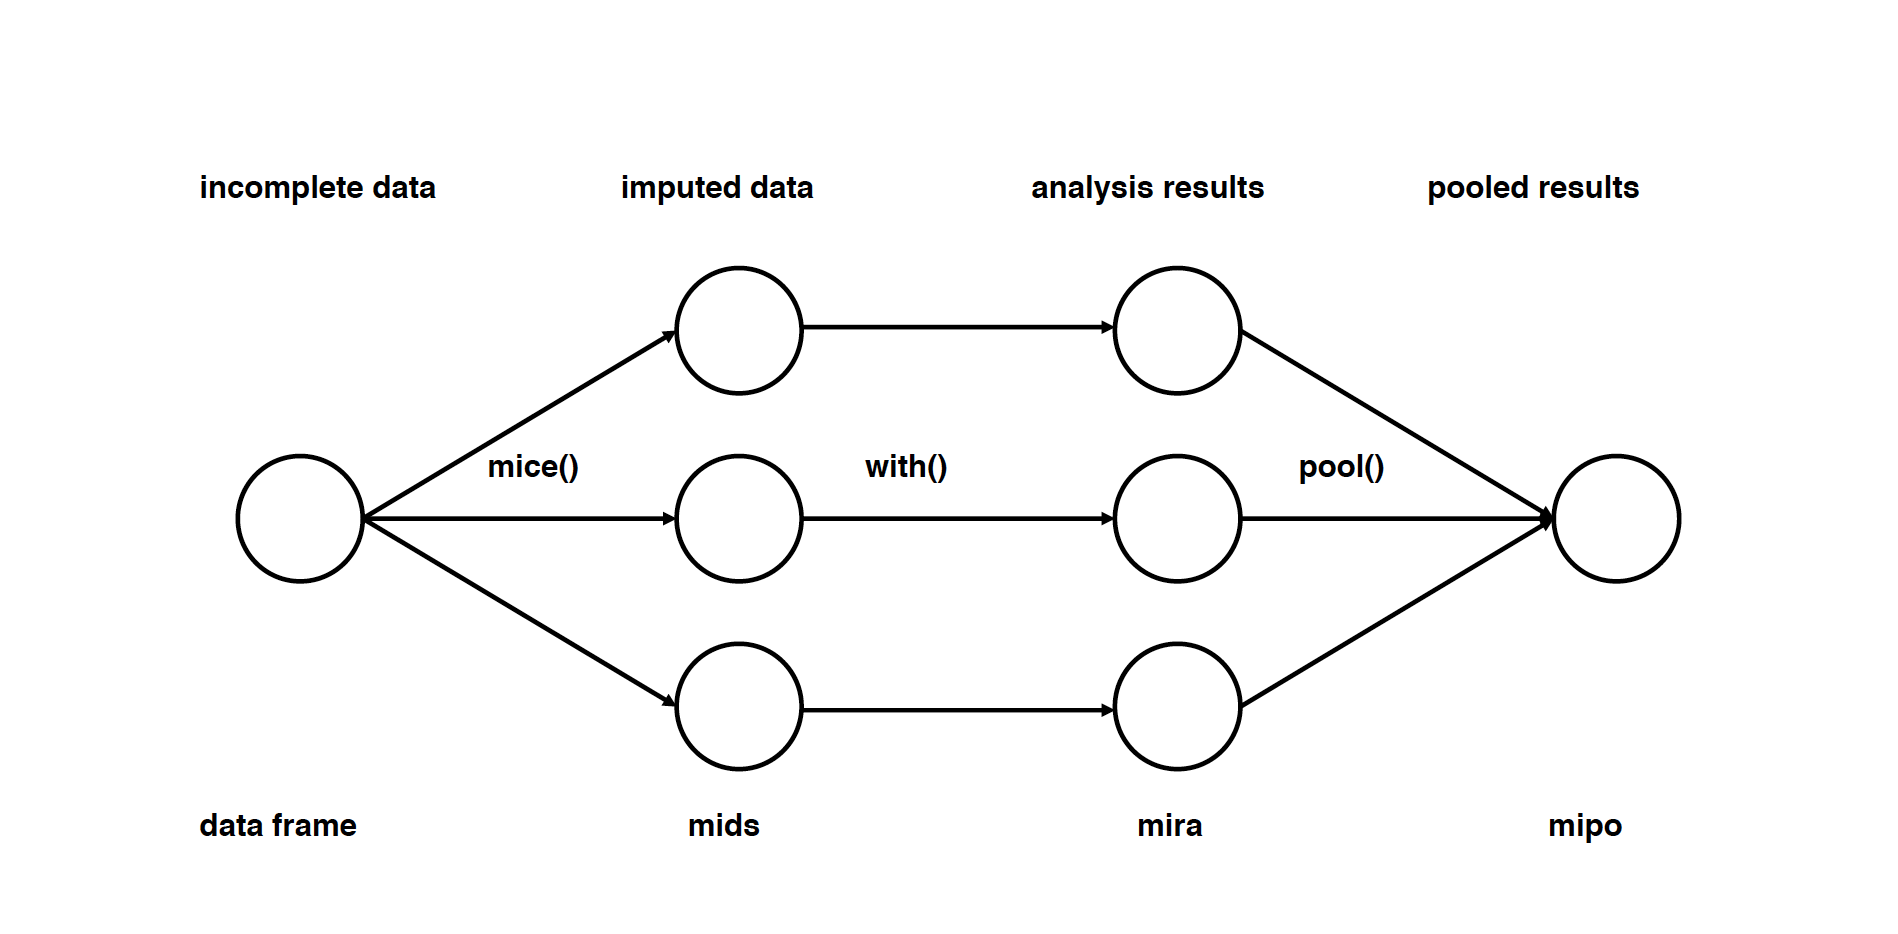

This type of imputation works by filling the missing data multiple times. 

Multiple Imputations (MIs) are much better than a single imputation as it measures the uncertainty of the missing values in a better way. The chained equations approach is also very flexible and can handle different variables of different data types (ie., continuous or binary).

Because multiple imputation involves creating multiple predictions for each missing value, the analyses of multiple imputed data take into account the uncertainty in the imputations and yield accurate standard errors. 

On a simple level, if there is not much information in the observed data (used in the imputation model) regarding the missing values, the imputations will be very variable, leading to high standard errors in the analyses. 

In contrast, if the observed data are highly predictive of the missing values the imputations will be more consistent across imputations, resulting in smaller, but still accurate, standard errors 

#### Example
We have 3 variables in our dataset: age, income, and gender, and all 3 have at least some missing values. 

The MAR assumption would imply that the probability of a particular variable being missing depends only on the observed values, and that, for example, whether someone’s income is missing does not depend on their (unobserved) income. 

In step 1 of the MICE process, each variable would first be imputed using, e.g., mean imputation, temporarily setting any missing value equal to the mean observed value for that variable. 

Then in step 2 the imputed mean values of age would be set back to missing. 

In step 3, a linear regression of age predicted by income and gender would be run using all cases where age was observed. 

In step 4, predictions of the missing age values would be obtained from that regression equation and imputed. At this point, age does not have any missingness. 

Steps 2–4 would then be repeated for the income variable. The originally missing values of income would be set back to missing and a linear regression of income predicted by age and gender would be run using all cases with income observed; imputations (predictions) would be obtained from that regression equation for the missing income values. 

Then, steps 2–4 would again be repeated for the variable gender. The originally missing values of gender would be set back to missing and a logistic regression of gender on age and income would be run using all cases with gender observed; predictions from that logistic regression model would be used to impute the missing gender values. 

This entire process of iterating through the 3 variables would be repeated until convergence; the observed data and the final set of imputed values would then constitute one <b>“complete” data set.</b>

In [26]:

# start the MICE training
imputed_training=mice(test_df.values)

In [27]:
imputed_test_df = pd.DataFrame(imputed_training, columns=['0', '1', '2', '3', '4', '5', '6', '7', 'target'])


In [28]:
imputed_test_df

,0,1,2,3,4,5,6,7,target
0,2.514220,39.0,5.228571,1.137143,580.0,3.314286,36.04,-119.40,1.125
1,3.731623,29.0,7.257143,1.242857,481.0,3.435714,36.05,-119.27,1.125
2,1.743200,30.0,4.120448,1.044818,1418.0,3.971989,36.10,-119.21,0.425
3,1.909100,29.0,5.353982,1.109145,1421.0,4.191740,36.06,-119.19,0.713
4,3.900000,41.0,5.883721,1.085271,408.0,3.162791,36.14,-119.19,0.859
5,2.058600,28.0,4.509434,1.037736,1434.0,3.865229,36.13,-119.13,0.409
6,3.152800,21.0,6.104839,1.010753,1145.0,3.077957,36.13,-119.08,1.137
7,1.710600,24.0,5.718987,1.032911,1169.0,2.959494,36.13,-119.03,0.955
8,1.635400,20.0,5.190283,1.105263,852.0,3.449393,36.15,-119.06,0.490
9,2.319400,25.0,5.210412,1.036876,1527.0,3.312364,36.15,-119.06,0.529


In [29]:
rmse = np.sqrt(mean_squared_error(original_column.values, (imputed_test_df['0']).values))

In [30]:
print(rmse)

0.5074950451682788


### 6- Imputation Using Deep Learning (Datawig):

This method works very well with categorical and non-numerical features. It is a library that learns Machine Learning models using Deep Neural Networks to impute missing values in a dataframe. It also supports both CPU and GPU for training.



In [31]:
import datawig

#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    input_columns=['1','2','3','4','5','6','7', 'target'], # column(s) containing information about the column we want to impute
    output_column= '0', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

#Fit an imputer model on the train data
imputer.fit(train_df=train_df, num_epochs=50)

#Impute missing values and return original dataframe with predictions
imputed = imputer.predict(test_df)


2019-05-02 02:37:53,621 [INFO]  Assuming 8 numeric input columns: 1, 2, 3, 4, 5, 6, 7, target
2019-05-02 02:37:53,622 [INFO]  Assuming 0 string input columns: 
2019-05-02 02:37:53,626 [INFO]  No output column name provided for ColumnEncoder using 0
2019-05-02 02:37:53,627 [INFO]  Assuming numeric output column: 0
2019-05-02 02:37:53,629 [INFO]  Using [[cpu(0)]] as the context for training
2019-05-02 02:37:53,641 [INFO]  Fitting label encoder <class 'datawig.column_encoders.NumericalEncoder'> on 18000 rows                             of training data
2019-05-02 02:37:53,649 [INFO]  Detected 0 rows with missing labels                         for column 0
2019-05-02 02:37:53,651 [INFO]  Dropping 0/18000 rows
2019-05-02 02:37:53,654 [INFO]  Detected 0 rows with missing labels                         for column 0
2019-05-02 02:37:53,655 [INFO]  Dropping 0/2000 rows
2019-05-02 02:37:53,657 [INFO]  Train: 18000, Test: 2000
2019-05-02 02:37:53,659 [INFO]  Fitting data encoder <class 'datawig.c

2019-05-02 02:38:02,896 [INFO]  Epoch[8] Train-cross-entropy=2.919749
2019-05-02 02:38:02,897 [INFO]  Epoch[8] Train-0-accuracy=0.000000
2019-05-02 02:38:02,897 [INFO]  Epoch[8] Time cost=1.016
2019-05-02 02:38:02,902 [INFO]  Saved checkpoint to "imputer_model/model-0008.params"
2019-05-02 02:38:02,961 [INFO]  Epoch[8] Validation-cross-entropy=3.101185
2019-05-02 02:38:02,962 [INFO]  Epoch[8] Validation-0-accuracy=0.000000
2019-05-02 02:38:03,459 [INFO]  Epoch[9] Batch [0-563]	Speed: 18259.58 samples/sec	cross-entropy=2.945539	0-accuracy=0.000000
2019-05-02 02:38:03,917 [INFO]  Epoch[9] Train-cross-entropy=2.933731
2019-05-02 02:38:03,918 [INFO]  Epoch[9] Train-0-accuracy=0.000000
2019-05-02 02:38:03,918 [INFO]  Epoch[9] Time cost=0.955
2019-05-02 02:38:03,924 [INFO]  Saved checkpoint to "imputer_model/model-0009.params"
2019-05-02 02:38:03,973 [INFO]  Epoch[9] Validation-cross-entropy=3.094612
2019-05-02 02:38:03,973 [INFO]  Epoch[9] Validation-0-accuracy=0.000000
2019-05-02 02:38:04,

In [32]:
imputed.head()

,0,1,2,3,4,5,6,7,target,0_imputed
20000,NaN,39.0,5.228571,1.137143,580.0,3.314286,36.04,-119.40,1.125,2.554000
20001,NaN,29.0,7.257143,1.242857,481.0,3.435714,36.05,-119.27,1.125,3.610564
20002,1.7432,30.0,4.120448,1.044818,1418.0,3.971989,36.10,-119.21,0.425,1.537421
20003,1.9091,29.0,5.353982,1.109145,1421.0,4.191740,36.06,-119.19,0.713,2.311756
20004,3.9000,41.0,5.883721,1.085271,408.0,3.162791,36.14,-119.19,0.859,2.810122


In [33]:
imputed.shape

(640, 10)

In [35]:
rmse = np.sqrt(mean_squared_error(original_column.values, (imputed['0_imputed']).values))


In [36]:
print(rmse)

0.7966533632714283


#### Pros:

- Quite accurate compared to other methods.

- It has some functions that can handle categorical data (Feature Encoder).

- It supports CPUs and GPUs.

#### Cons:

- Single Column imputation.

- Can be quite slow with large datasets.

- You have to specify the columns that contain information about the target column that will be imputed.


### What is Datawig?

Paper: https://ssc.io/pdf/p2017-biessmann.pdf

Datawig is a tool that learns all parameters of the entire imputation pipeline automatically in an end-to-end fashion, rendering it attractive as a generic plugin both for engineers in charge of data pipelines where data completeness is relevant, as well as for practitioners without expertise in machine learning who need to impute missing values in tables with non-numerical data.

It's an imputation approach for tables with attributes containing <b>non-numerical</b> data, including <b>unstructured text and categorical data</b>. 

To reduce the amount of custom feature extraction glue code for making non-numerical data amenable to standard imputation methods, the system allows its users to combine and automatically select feature extractors for categorical and sequential non-numerical data, leveraging state of the art <b>deep learning methods</b> and efficient optimization tools.

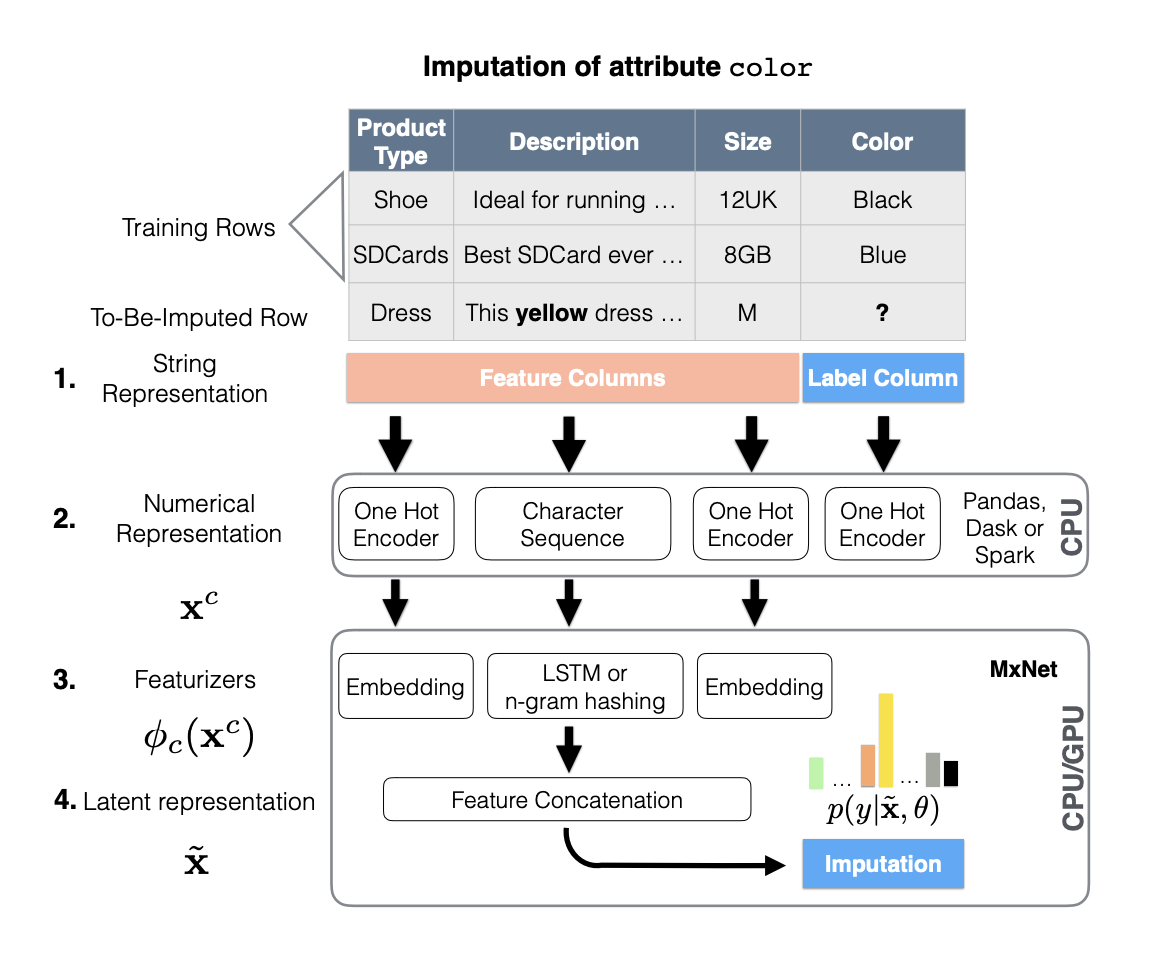

#### String representation
In this stage, the columns are separated into input/feature and to-be-imputed/target columns. 

Data is still in their textual representation. All rows that have an observed value are considered for training data (and validation or testing). Rows with missing values are considered for imputation.

#### Numerical representation
In order to train machine learning methods for imputation, we need to first create a numerical
representation of input and target columns. 

Depending on the type of data, we either model columns as categorical variables or sequential variables (such as free text fields).

#### Feature representation
The quality of predictions of machine learning models depends critically on the feature representation used. 

We build on a large body of work on embeddings for categorical and sequential data and use learnable feature representations.

#### Imputation
We finally compute the likelihood of all potential values from the concatenation of all extracted features.

API Docs: https://datawig.readthedocs.io/en/latest/#

### Things to know

#### ColumnEncoder

Defines an abstract super class of column encoders that transforms the raw data of a column (e.g. strings from a product title) into an encoded numerical representation.

There are a few options for ColumnEncoders (subclasses) depending on the column data type:

- <b>SequentialEncoder</b>: for sequences of string symbols (e.g. characters or words)

- <b>BowEncoder</b>: bag-of-word representation for strings, as sparse vectors

- <b>CategoricalEncoder</b>: for categorical variables (one-hot encoding)

- <b>NumericalEncoder</b>: for numerical values

#### Featurizer
Defines a specific featurizer for data that has been encoded into a numerical format by ColumnEncoder. The Featurizer is used to feed data into the imputation model’s computational graph for training and prediction.

There are a few options for Featurizers depending on which ColumnEncoder was used for a particular column:

- <b>LSTMFeaturizer</b> maps an input representing a sequence of symbols into a latent vector using an LSTM

- <b>BowFeaturizer</b> used with BowEncoder on string data

- <b>EmbeddingFeaturizer</b> maps encoded catagorical data into a vector representations (word-embeddings)

- <b>NumericalFeaturizer</b> extracts features from numerical data using fully connected layers


#### SimpleImputer
Using SimpleImputer is the easiest way to deploy an imputation model on your dataset with DataWig. As the name suggests, the SimpleImputer is straightforward to call from a python script and uses default encoders and featurizers that usually yield good results on a variety of datasets.

#### Imputer
Imputer is the backbone of the SimpleImputer and is responsible for running the preprocessing code, creating the model, executing training, and making predictions. Using the Imputer enables more flexibility with specifying model parameters, such as using particular encoders and featurizers rather than the default ones that SimpleImputer uses.

### Introduction to Imputer

In [37]:
df = pd.read_csv('datawig/examples/mae_val_dataset.csv')
df_train, df_test = random_split(df, split_ratios=[0.8, 0.2])

In [38]:
df_train.head()

,color,finish,title,text
609,black,powder coated,Jamco Bin Cabinet 14 ga. 78 in H 36 in W,Product Specifications SKU GR-18H155 Item Bin ...
253,natural,satin,"Jamco # XW136 ( 9JFT4 ) - Work Stand, SS, 36 I...",Product Description Item: Work Table Load Capa...
257,red,matte,"Adjustable Handles, 1.18, M8, Red",Product Details The Kipp® Novo-grip adjustable...
52,gray,powder coat,"Ventilated Welded Storage Locker, Gray",ItemBulk Storage Locker Assembled/UnassembledA...
664,red,powder coated,"ISO D Die Spring, Heavy Duty, 1-1/2x4In",Zoro #: G9072621 Mfr #: 305716D End Type: Clos...


In [39]:
df_train.shape

(552, 4)

In [40]:
df_test.shape

(138, 4)

In [41]:
df_test.head()

,color,finish,title,text
516,gray,powder coated,"Wardrobe Locker, (3) Wide, (3) Openings","Zoro #: G0689090 Mfr #: U3288-1A-HG Legs: 6"" I..."
659,gray,powder coated,Little Giant # WX-4284-34 ( 34AW25 ) - Workben...,Product Description Item: Workbench Load Capac...
213,silver,polished,Owens Products Classic Series Extruded Cab Len...,Full size extruded aluminum stone guards prote...
465,black,powder coat,"Peerless Industries, Inc. SF640P TV Brackets",Universal mount fits displays with mounting pa...
206,gray,powder coat,"Hallowell 36"" x 18"" x 87"" Add-On Steel Shelvin...","Shelving Unit, Shelving Type Add-On, Shelving ..."


#### Default Imputer
The key difference with the Imputer is specifying the Encoders and Featurizers used for particular columns in your dataset. Once this is done, initializing the model, training, and making predictions with the Imputer is similar to the SimpleImputer

In [42]:
#Specify encoders and featurizers
data_encoder_cols = [BowEncoder('title'), BowEncoder('text')]
label_encoder_cols = [CategoricalEncoder('finish')]
data_featurizer_cols = [BowFeaturizer('title'), BowFeaturizer('text')]

imputer = Imputer(
    data_featurizers=data_featurizer_cols,
    label_encoders=label_encoder_cols,
    data_encoders=data_encoder_cols,
    output_path='imputer_model'
)

imputer.fit(train_df=df_train)
predictions = imputer.predict(df_test)

2019-05-02 02:39:16,473 [INFO]  No output column name provided for ColumnEncoder using title
2019-05-02 02:39:16,482 [INFO]  No output column name provided for ColumnEncoder using text
2019-05-02 02:39:16,482 [INFO]  No output column name provided for ColumnEncoder using finish
2019-05-02 02:39:16,484 [INFO]  Using [[cpu(0)]] as the context for training
2019-05-02 02:39:16,488 [INFO]  Fitting label encoder <class 'datawig.column_encoders.CategoricalEncoder'> on 496 rows                             of training data
2019-05-02 02:39:16,491 [INFO]  16 most often encountered discrete values:                      ['powder coated' 'powder coat' 'matte' 'black' 'polished' 'white' 'chrome'
 'stainless steel' 'gloss' 'white powder coat' 'glossy' 'chrome metal'
 'painted' 'black powder coat' 'satin' 'natural']
2019-05-02 02:39:16,492 [WARNING]  CategoricalEncoder for column finish                                found only 58 occurrences of value powder coat
2019-05-02 02:39:16,493 [WARNING]  Cat

2019-05-02 02:39:36,665 [INFO]  Epoch[3] Train-finish-accuracy=0.530242
2019-05-02 02:39:36,666 [INFO]  Epoch[3] Time cost=4.060
2019-05-02 02:39:36,825 [INFO]  Saved checkpoint to "imputer_model/model-0003.params"
2019-05-02 02:39:37,209 [INFO]  Epoch[3] Validation-cross-entropy=1.665309
2019-05-02 02:39:37,295 [INFO]  Epoch[3] Validation-finish-accuracy=0.531250
2019-05-02 02:39:39,525 [INFO]  Epoch[4] Batch [0-16]	Speed: 122.51 samples/sec	cross-entropy=1.384219	finish-accuracy=0.602941
2019-05-02 02:39:41,361 [INFO]  Epoch[4] Train-cross-entropy=1.335580
2019-05-02 02:39:41,361 [INFO]  Epoch[4] Train-finish-accuracy=0.645161
2019-05-02 02:39:41,362 [INFO]  Epoch[4] Time cost=4.065
2019-05-02 02:39:41,513 [INFO]  Saved checkpoint to "imputer_model/model-0004.params"
2019-05-02 02:39:41,897 [INFO]  Epoch[4] Validation-cross-entropy=1.543826
2019-05-02 02:39:41,898 [INFO]  Epoch[4] Validation-finish-accuracy=0.640625
2019-05-02 02:39:44,134 [INFO]  Epoch[5] Batch [0-16]	Speed: 121.78 

2019-05-02 02:40:41,769 [INFO]  Epoch[17] Validation-finish-accuracy=0.812500
2019-05-02 02:40:44,011 [INFO]  Epoch[18] Batch [0-16]	Speed: 121.44 samples/sec	cross-entropy=0.374442	finish-accuracy=0.985294
2019-05-02 02:40:45,952 [INFO]  Epoch[18] Train-cross-entropy=0.355260
2019-05-02 02:40:45,955 [INFO]  Epoch[18] Train-finish-accuracy=0.989919
2019-05-02 02:40:45,955 [INFO]  Epoch[18] Time cost=4.186
2019-05-02 02:40:46,132 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-05-02 02:40:46,582 [INFO]  Epoch[18] Validation-cross-entropy=0.829217
2019-05-02 02:40:46,582 [INFO]  Epoch[18] Validation-finish-accuracy=0.812500
2019-05-02 02:40:49,228 [INFO]  Epoch[19] Batch [0-16]	Speed: 102.86 samples/sec	cross-entropy=0.346678	finish-accuracy=0.988971
2019-05-02 02:40:51,153 [INFO]  Epoch[19] Train-cross-entropy=0.328985
2019-05-02 02:40:51,154 [INFO]  Epoch[19] Train-finish-accuracy=0.991935
2019-05-02 02:40:51,155 [INFO]  Epoch[19] Time cost=4.572
2019-05-02 02:40:51,

2019-05-02 02:41:53,010 [INFO]  Epoch[32] Train-cross-entropy=0.145656
2019-05-02 02:41:53,011 [INFO]  Epoch[32] Train-finish-accuracy=0.997984
2019-05-02 02:41:53,011 [INFO]  Epoch[32] Time cost=4.090
2019-05-02 02:41:53,170 [INFO]  Saved checkpoint to "imputer_model/model-0032.params"
2019-05-02 02:41:53,562 [INFO]  Epoch[32] Validation-cross-entropy=0.674621
2019-05-02 02:41:53,562 [INFO]  Epoch[32] Validation-finish-accuracy=0.796875
2019-05-02 02:41:55,785 [INFO]  Epoch[33] Batch [0-16]	Speed: 122.70 samples/sec	cross-entropy=0.144669	finish-accuracy=0.996324
2019-05-02 02:41:57,616 [INFO]  Epoch[33] Train-cross-entropy=0.138417
2019-05-02 02:41:57,617 [INFO]  Epoch[33] Train-finish-accuracy=0.997984
2019-05-02 02:41:57,618 [INFO]  Epoch[33] Time cost=4.055
2019-05-02 02:41:57,773 [INFO]  Saved checkpoint to "imputer_model/model-0033.params"
2019-05-02 02:41:58,156 [INFO]  Epoch[33] Validation-cross-entropy=0.668716
2019-05-02 02:41:58,157 [INFO]  Epoch[33] Validation-finish-accur

2019-05-02 02:42:57,552 [INFO]  Saved checkpoint to "imputer_model/model-0046.params"
2019-05-02 02:42:57,936 [INFO]  Epoch[46] Validation-cross-entropy=0.616492
2019-05-02 02:42:57,937 [INFO]  Epoch[46] Validation-finish-accuracy=0.781250
2019-05-02 02:43:00,162 [INFO]  Epoch[47] Batch [0-16]	Speed: 122.50 samples/sec	cross-entropy=0.078768	finish-accuracy=1.000000
2019-05-02 02:43:01,992 [INFO]  Epoch[47] Train-cross-entropy=0.075956
2019-05-02 02:43:01,993 [INFO]  Epoch[47] Train-finish-accuracy=1.000000
2019-05-02 02:43:01,994 [INFO]  Epoch[47] Time cost=4.056
2019-05-02 02:43:02,143 [INFO]  Saved checkpoint to "imputer_model/model-0047.params"
2019-05-02 02:43:02,528 [INFO]  Epoch[47] Validation-cross-entropy=0.613739
2019-05-02 02:43:02,530 [INFO]  Epoch[47] Validation-finish-accuracy=0.781250
2019-05-02 02:43:04,762 [INFO]  Epoch[48] Batch [0-16]	Speed: 121.93 samples/sec	cross-entropy=0.075906	finish-accuracy=1.000000
2019-05-02 02:43:06,589 [INFO]  Epoch[48] Train-cross-entrop

2019-05-02 02:44:04,625 [INFO]  Epoch[61] Batch [0-16]	Speed: 122.82 samples/sec	cross-entropy=0.049422	finish-accuracy=1.000000
2019-05-02 02:44:06,459 [INFO]  Epoch[61] Train-cross-entropy=0.047924
2019-05-02 02:44:06,460 [INFO]  Epoch[61] Train-finish-accuracy=1.000000
2019-05-02 02:44:06,461 [INFO]  Epoch[61] Time cost=4.055
2019-05-02 02:44:06,619 [INFO]  Saved checkpoint to "imputer_model/model-0061.params"
2019-05-02 02:44:07,001 [INFO]  Epoch[61] Validation-cross-entropy=0.585115
2019-05-02 02:44:07,002 [INFO]  Epoch[61] Validation-finish-accuracy=0.796875
2019-05-02 02:44:09,231 [INFO]  Epoch[62] Batch [0-16]	Speed: 122.22 samples/sec	cross-entropy=0.047975	finish-accuracy=1.000000
2019-05-02 02:44:11,062 [INFO]  Epoch[62] Train-cross-entropy=0.046536
2019-05-02 02:44:11,063 [INFO]  Epoch[62] Train-finish-accuracy=1.000000
2019-05-02 02:44:11,064 [INFO]  Epoch[62] Time cost=4.061
2019-05-02 02:44:11,223 [INFO]  Saved checkpoint to "imputer_model/model-0062.params"
2019-05-02 0

2019-05-02 02:45:11,365 [INFO]  Epoch[75] Train-finish-accuracy=1.000000
2019-05-02 02:45:11,366 [INFO]  Epoch[75] Time cost=4.146
2019-05-02 02:45:11,531 [INFO]  Saved checkpoint to "imputer_model/model-0075.params"
2019-05-02 02:45:11,934 [INFO]  Epoch[75] Validation-cross-entropy=0.567607
2019-05-02 02:45:11,935 [INFO]  Epoch[75] Validation-finish-accuracy=0.812500
2019-05-02 02:45:14,166 [INFO]  Epoch[76] Batch [0-16]	Speed: 122.20 samples/sec	cross-entropy=0.032792	finish-accuracy=1.000000
2019-05-02 02:45:15,998 [INFO]  Epoch[76] Train-cross-entropy=0.031936
2019-05-02 02:45:15,998 [INFO]  Epoch[76] Train-finish-accuracy=1.000000
2019-05-02 02:45:15,999 [INFO]  Epoch[76] Time cost=4.063
2019-05-02 02:45:16,155 [INFO]  Saved checkpoint to "imputer_model/model-0076.params"
2019-05-02 02:45:16,539 [INFO]  Epoch[76] Validation-cross-entropy=0.566614
2019-05-02 02:45:16,540 [INFO]  Epoch[76] Validation-finish-accuracy=0.812500
2019-05-02 02:45:18,821 [INFO]  Epoch[77] Batch [0-16]	Spe

2019-05-02 02:46:18,678 [INFO]  Epoch[89] Validation-cross-entropy=0.555835
2019-05-02 02:46:18,679 [INFO]  Epoch[89] Validation-finish-accuracy=0.812500
2019-05-02 02:46:20,900 [INFO]  Epoch[90] Batch [0-16]	Speed: 122.75 samples/sec	cross-entropy=0.023552	finish-accuracy=1.000000
2019-05-02 02:46:22,721 [INFO]  Epoch[90] Train-cross-entropy=0.023007
2019-05-02 02:46:22,722 [INFO]  Epoch[90] Train-finish-accuracy=1.000000
2019-05-02 02:46:22,722 [INFO]  Epoch[90] Time cost=4.042
2019-05-02 02:46:22,877 [INFO]  Saved checkpoint to "imputer_model/model-0090.params"
2019-05-02 02:46:23,260 [INFO]  Epoch[90] Validation-cross-entropy=0.555142
2019-05-02 02:46:23,260 [INFO]  Epoch[90] Validation-finish-accuracy=0.812500
2019-05-02 02:46:25,473 [INFO]  Epoch[91] Batch [0-16]	Speed: 123.07 samples/sec	cross-entropy=0.023035	finish-accuracy=1.000000
2019-05-02 02:46:27,307 [INFO]  Epoch[91] Train-cross-entropy=0.022506
2019-05-02 02:46:27,308 [INFO]  Epoch[91] Train-finish-accuracy=1.000000
20

2019-05-02 02:47:06,918 [INFO]  Attribute finish, Label: gloss	Reaching 0.0 precision / 0.0 recall at threshold 0.028026526793837547
2019-05-02 02:47:06,920 [INFO]  Attribute finish, Label: white powder coat	Reaching 1.0 precision / 0.0 recall at threshold 0.9981845021247864
2019-05-02 02:47:06,921 [INFO]  Attribute finish, Label: glossy	Reaching 1.0 precision / 0.0 recall at threshold 0.9981511235237122
2019-05-02 02:47:06,923 [INFO]  Attribute finish, Label: chrome metal	Reaching 1.0 precision / 0.0 recall at threshold 0.9988889098167419
2019-05-02 02:47:06,926 [INFO]  Attribute finish, Label: painted	Reaching 0.5 precision / 0.5 recall at threshold 0.596571147441864
2019-05-02 02:47:06,928 [INFO]  Attribute finish, Label: black powder coat	Reaching 1.0 precision / 0.0 recall at threshold 0.9802222847938538
2019-05-02 02:47:06,930 [INFO]  Attribute finish, Label: satin	Reaching 1.0 precision / 0.0 recall at threshold 0.9892750382423401
2019-05-02 02:47:06,933 [INFO]  save metrics in 

2019-05-02 02:47:07,111 [INFO]  Deleting imputer_model/model-0093.params
2019-05-02 02:47:07,112 [INFO]  Deleting imputer_model/model-0072.params
2019-05-02 02:47:07,151 [INFO]  Data Encoding - Encoded 144 rows of column                         title with <class 'datawig.column_encoders.BowEncoder'> into                         <class 'scipy.sparse.csr.csr_matrix'> of shape (144, 262144)                         and then into shape (144, 262144)
2019-05-02 02:47:07,393 [INFO]  Data Encoding - Encoded 144 rows of column                         text with <class 'datawig.column_encoders.BowEncoder'> into                         <class 'scipy.sparse.csr.csr_matrix'> of shape (144, 262144)                         and then into shape (144, 262144)
2019-05-02 02:47:07,394 [INFO]  CategoricalEncoder encoding 144 rows with                     16 tokens from column finish to                     column finish
2019-05-02 02:47:07,397 [INFO]  Label Encoding - Encoded 144 rows of column              

For the input columns that contain data useful for imputation, the Imputer expects you to specify the particular encoders and featurizers. For the label column that your are trying to impute, only specifying the type of encoder is necessary.



In [43]:
predictions.head()

,color,finish,title,text,finish_imputed,finish_imputed_proba
516,gray,powder coated,"Wardrobe Locker, (3) Wide, (3) Openings","Zoro #: G0689090 Mfr #: U3288-1A-HG Legs: 6"" I...",powder coated,0.999732
659,gray,powder coated,Little Giant # WX-4284-34 ( 34AW25 ) - Workben...,Product Description Item: Workbench Load Capac...,powder coated,0.985838
213,silver,polished,Owens Products Classic Series Extruded Cab Len...,Full size extruded aluminum stone guards prote...,white,0.437017
465,black,powder coat,"Peerless Industries, Inc. SF640P TV Brackets",Universal mount fits displays with mounting pa...,black,0.376496
206,gray,powder coat,"Hallowell 36"" x 18"" x 87"" Add-On Steel Shelvin...","Shelving Unit, Shelving Type Add-On, Shelving ...",powder coat,0.993671


In [44]:
predictions.shape

(138, 6)

In [45]:
f1 = f1_score(predictions['finish'], predictions['finish_imputed'], average='weighted')

print("F1 score: ", f1)

# Print overall classification report
#print(classification_report(predictions['finish'], predictions['finish_imputed']))

F1 score:  0.7445021868449175
